In [208]:
import sys
sys.path.insert(1, '../../ana_tools')
import getters, tools, graphic_tools, setters
import matplotlib.pyplot as plt
plt.style.use('../../ana_tools/presentation.mplstyle')
import numpy as np
path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
plateaus = getters.get_plateaus()
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
import gc
gc.enable()
from scipy.optimize import curve_fit

/eos/home-i01/j/jcapotor/SWAN_projects/FBG_TMS
/eos/home-i01/j/jcapotor/SWAN_projects/FBG_TMS/ana_tools/plateaus.json


In [209]:
def line(x,a,b):
    return a+b*x

## 20230321 ##
# Description of the run #

* This run is a *temperature profile* run. It has 4 plateaus of 4 hour long each and a total elapsed time of 22h.
* It has only one fibre connected, *FBG2*, containing 4 sensors and coating type *ORMOCER*

The first thing to do is to get the objective temperature and humidity thta the climatic chamber was trying to follow and out of that obtain the initial and final times of each of the plateaus. *This task has been performed prior to teh start of this study*

In [210]:
date = "20230321"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)

Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:01<00:00,  9.26it/s]


Keys to read: ['Temp1', 'Temp2']


Reading temperature key: Temp: 100%|██████████| 2/2 [00:00<00:00, 42.27it/s]


Keys to read: ['Hum1', 'Hum2']


Reading humidity key: Hum: 100%|██████████| 2/2 [00:00<00:00, 80.30it/s]


[789.97961161  13.17630549]
[795.23838817  13.26387928]
[794.70503665  13.25531454]
[796.98195558  13.29295833]


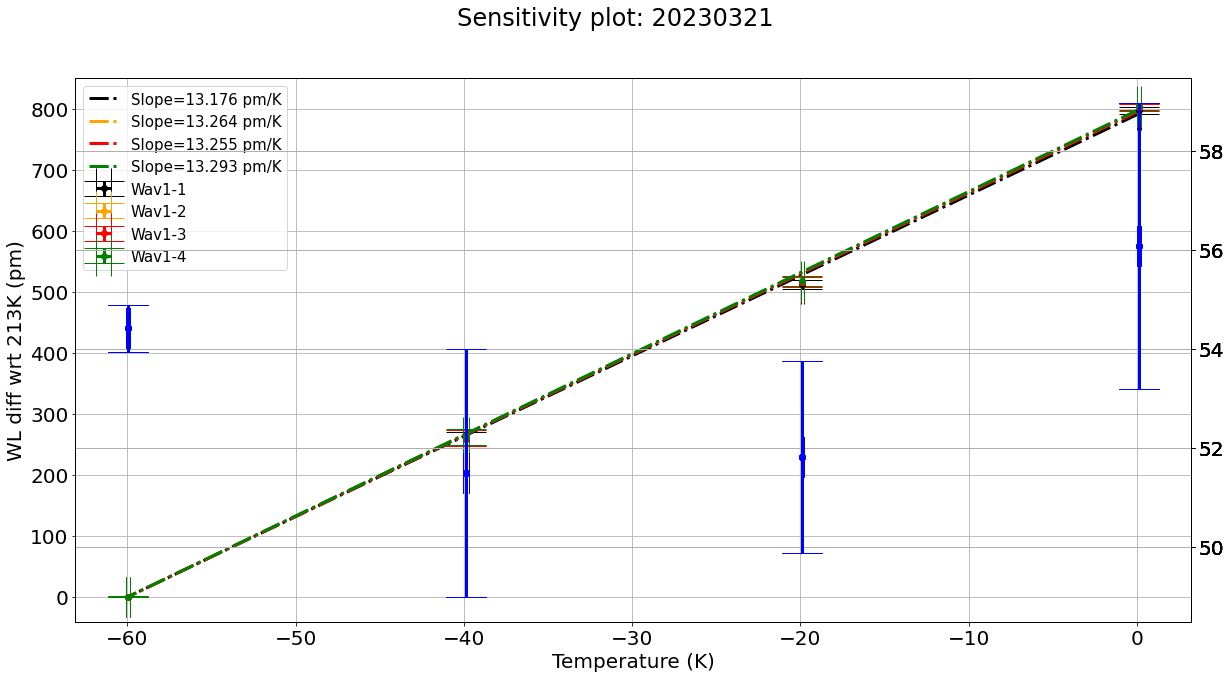

In [211]:
def plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes):
    twin_axes = axes.twinx()
    fig.set_size_inches(20, 10)
    fig.suptitle("Sensitivity plot: " + date)
    t0 = plateaus[date]["213_down"][0]
    tf = plateaus[date]["213_down"][1]
    p0 = np.mean(peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)][sens])
    temps, wls, hums = [], [], []
    temps_err, wls_err, hums_err = [], [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0]
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        pcut = peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)]
        hcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0)&(climatic_chamber["Timestamp"]<tf)]
        
        temps.append(np.mean(hcut["T"]))
        wls.append(1e12*np.mean(pcut[sens]-p0))
        temps_err.append(np.std(hcut["T"]))
        wls_err.append(1e12*np.std(pcut[sens]-p0))
        hums.append(np.mean(hcut["RH"]))
        hums_err.append(np.std(hcut["RH"]))
    axes.errorbar(
        temps,
        wls,
        xerr=temps_err,
        yerr=wls_err,
        fmt="o",
        label=sens,
        capsize=20,
        color=colors[sens]
    )
    twin_axes.errorbar(
        temps,
        hums,
        xerr=temps_err,
        yerr=hums_err,
        fmt="o",
        label="Humidity",
        capsize=20,
        color="blue"
    )
    axes.set_xlabel("Temperature (K)")
    axes.set_ylabel("WL diff wrt 213K (pm)")
    twin_axes.set_xlabel("Humidity (%)")
    popt,pcov = curve_fit(line, xdata=temps, ydata=wls, sigma=wls_err)
    print(popt)
    axes.plot(
        temps,
        line(np.array(temps), popt[0], popt[1]),
        label=r"Slope={0:.3f} pm/K".format(popt[1]),
        color=colors[sens],
        linestyle="-."
    )
    axes.legend(fontsize=15)
    return temps, hums, wls, popt
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 70.71it/s]


[767.2460732   12.83870858]
[772.8930922   12.94760366]
[771.28338795  12.91331304]
[776.26654067  13.00028798]


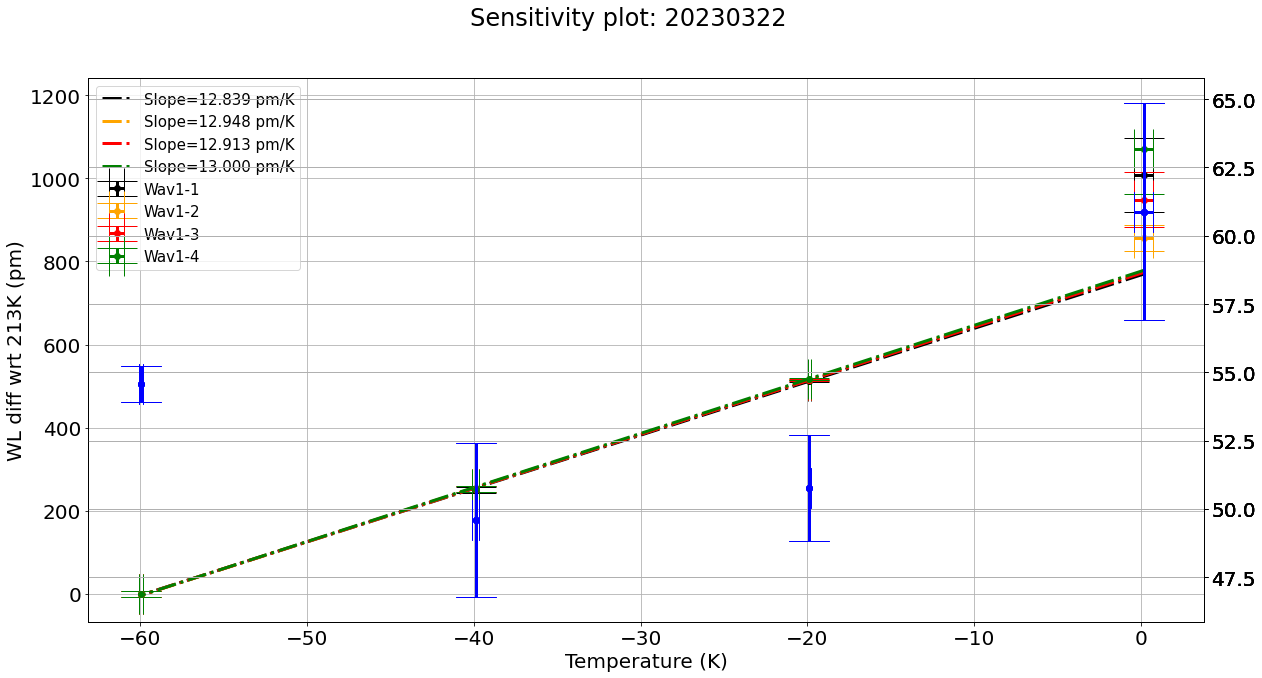

In [212]:
date = "20230322"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 30.41it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 73.31it/s]


[821.1502196   13.81018361]
[821.18470709  13.80918469]
[823.32615517  13.84440436]
[827.39258382  13.91148784]
[793.66442278  13.42404364]
[796.83918133  13.486848  ]
[800.63258342  13.54978419]
[802.59040626  13.59361122]


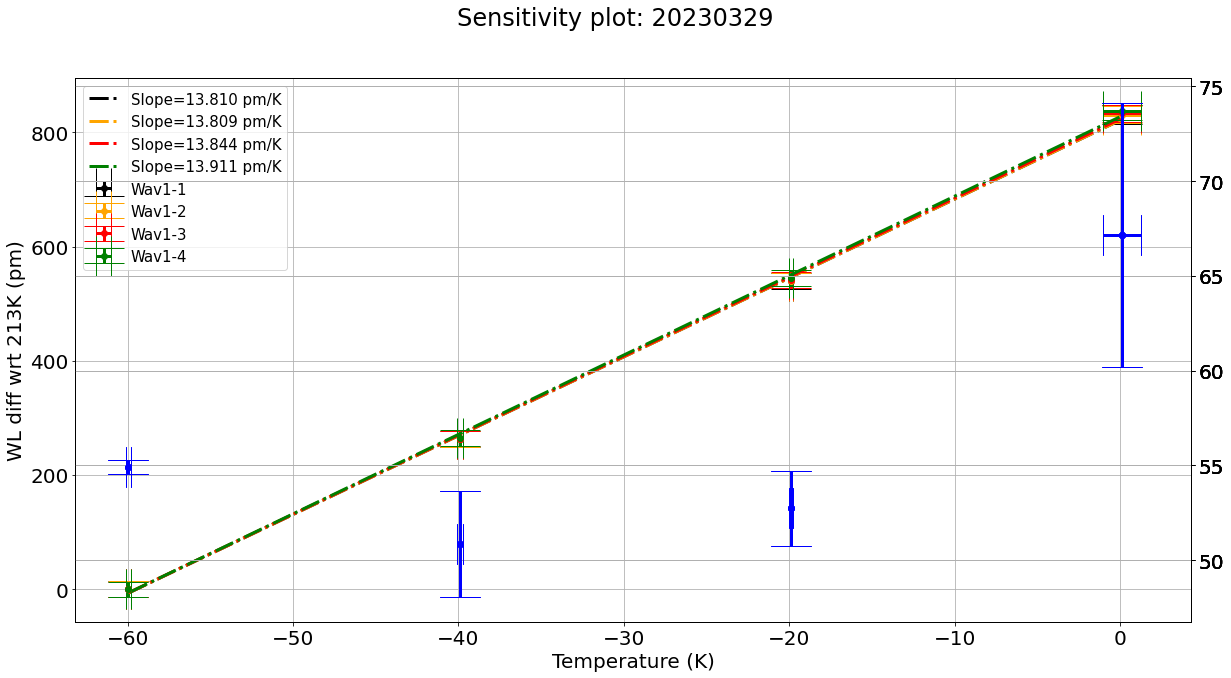

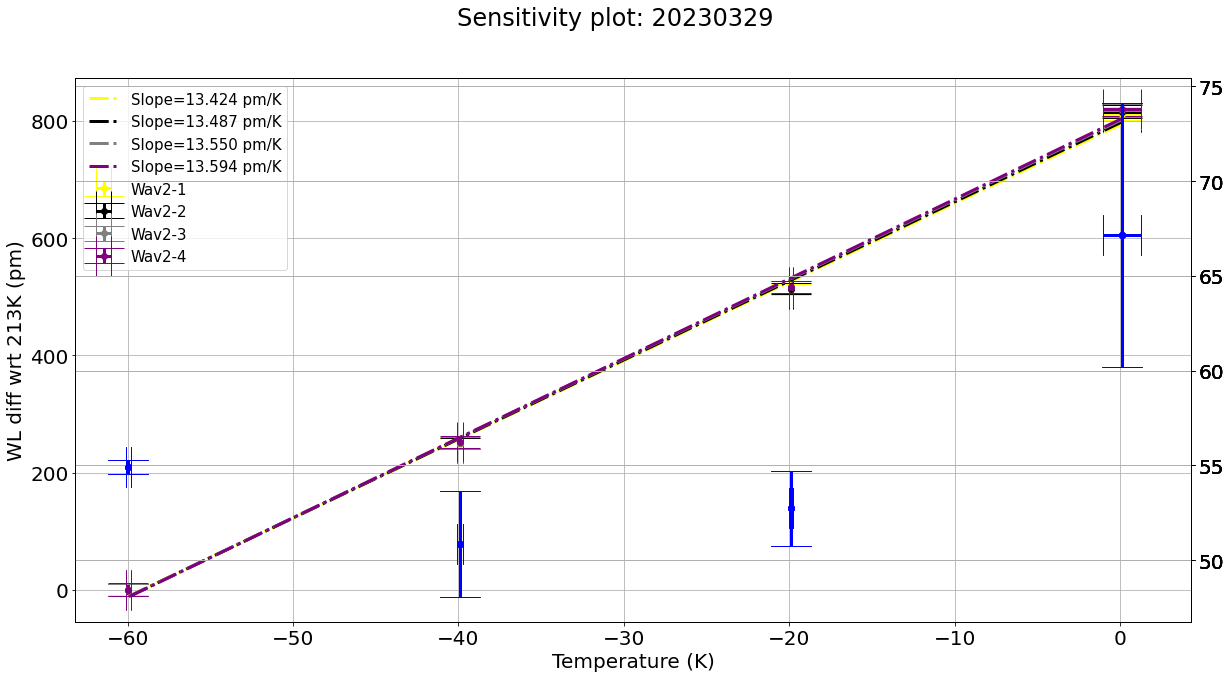

In [213]:
date = "20230329"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav2-1", "Wav2-2", "Wav2-3", "Wav2-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:01<00:00,  8.50it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 27.45it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 65.29it/s]


[89.38067966 -1.45025536]
[58.00328275 -0.94320428]
[66.22375697 -1.05782917]
[88.92205185 -1.43361487]


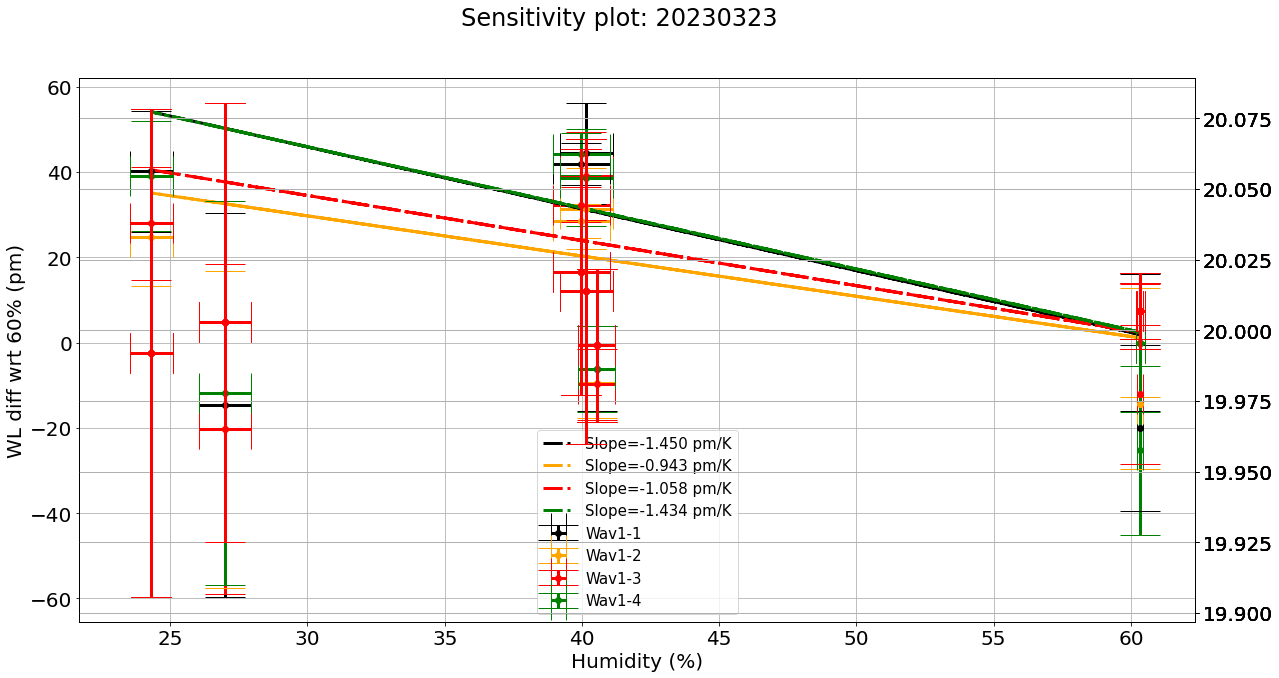

In [214]:
date = "20230323"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
def plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes):
    twin_axes = axes.twinx()
    fig.set_size_inches(20, 10)
    fig.suptitle("Sensitivity plot: " + date)
    t0 = plateaus[date]["60_up"][0]
    tf = plateaus[date]["60_up"][1]
    p0 = np.mean(peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)][sens])
    temps, wls, hums = [], [], []
    temps_err, wls_err, hums_err = [], [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0]
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        pcut = peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)]
        hcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0)&(climatic_chamber["Timestamp"]<tf)]
        
        temps.append(np.mean(hcut["T"]))
        wls.append(1e12*np.mean(pcut[sens]-p0))
        temps_err.append(np.std(hcut["T"]))
        wls_err.append(1e12*np.std(pcut[sens]-p0))
        hums.append(np.mean(hcut["RH"]))
        hums_err.append(np.std(hcut["RH"]))
    axes.errorbar(
        hums,
        wls,
        xerr=hums_err,
        yerr=wls_err,
        fmt="o",
        label=sens,
        capsize=20,
        color=colors[sens]
    )
    twin_axes.errorbar(
        hums,
        temps,
        xerr=hums_err,
        yerr=temps_err,
        fmt="o",
        label="Temperature",
        capsize=20,
        color="red"
    )
    axes.set_xlabel("Humidity (%)")
    axes.set_ylabel("WL diff wrt 60% (pm)")
    twin_axes.set_xlabel("Temperature (K)")
    popt,pcov = curve_fit(line, xdata=hums, ydata=wls, sigma=wls_err)
    print(popt)
    axes.plot(
        hums,
        line(np.array(hums), popt[0], popt[1]),
        label=r"Slope={0:.3f} pm/K".format(popt[1]),
        color=colors[sens],
        linestyle="-."
    )
    axes.legend(fontsize=15)
    return temps, hums, wls, popt
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:03<00:00,  6.00it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 64.94it/s]


[131.49640754  -2.27598641]
[93.72296612 -1.64152723]
[98.52254907 -1.72299313]
[129.55504778  -2.21062568]


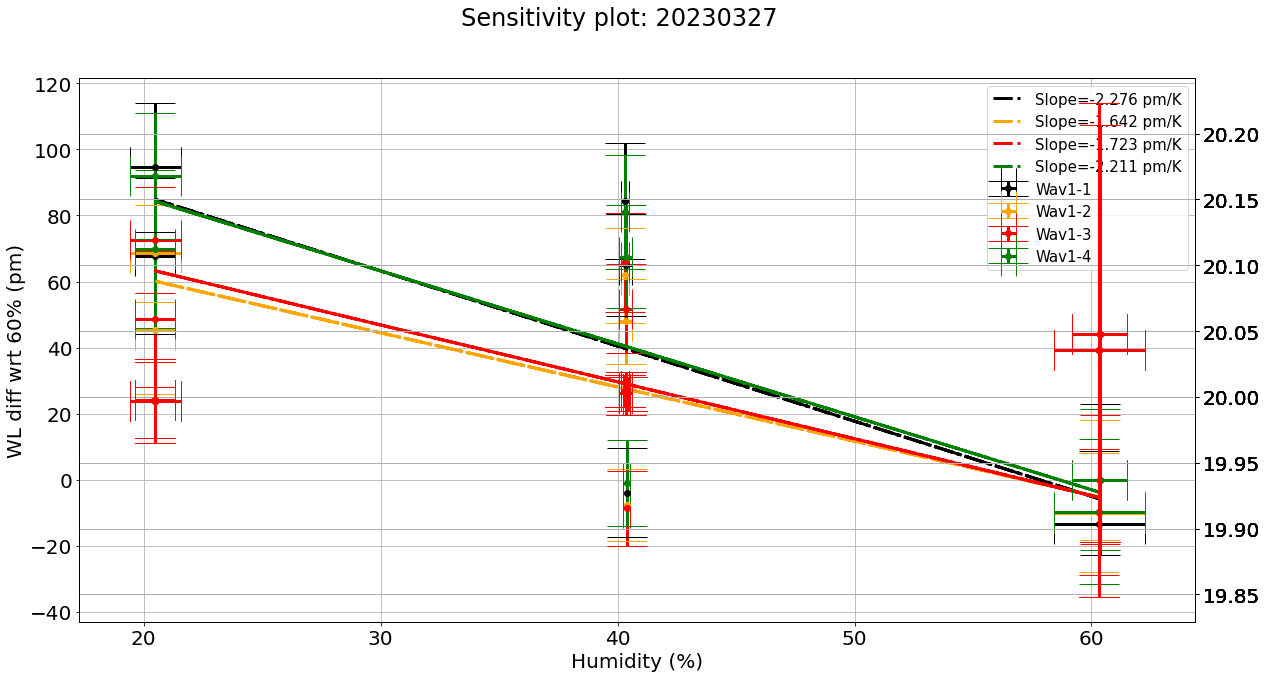

In [215]:
date = "20230327"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 26.92it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 69.09it/s]


[ 4.29625611 -0.08483957]
[-6.96847546  0.11218693]
[-10.08875808   0.16931741]
[-10.65647853   0.18150905]
[-86.66318325   1.38731531]
[-93.67334753   1.49897674]
[-98.4473885    1.57864773]
[-97.52933626   1.57083221]


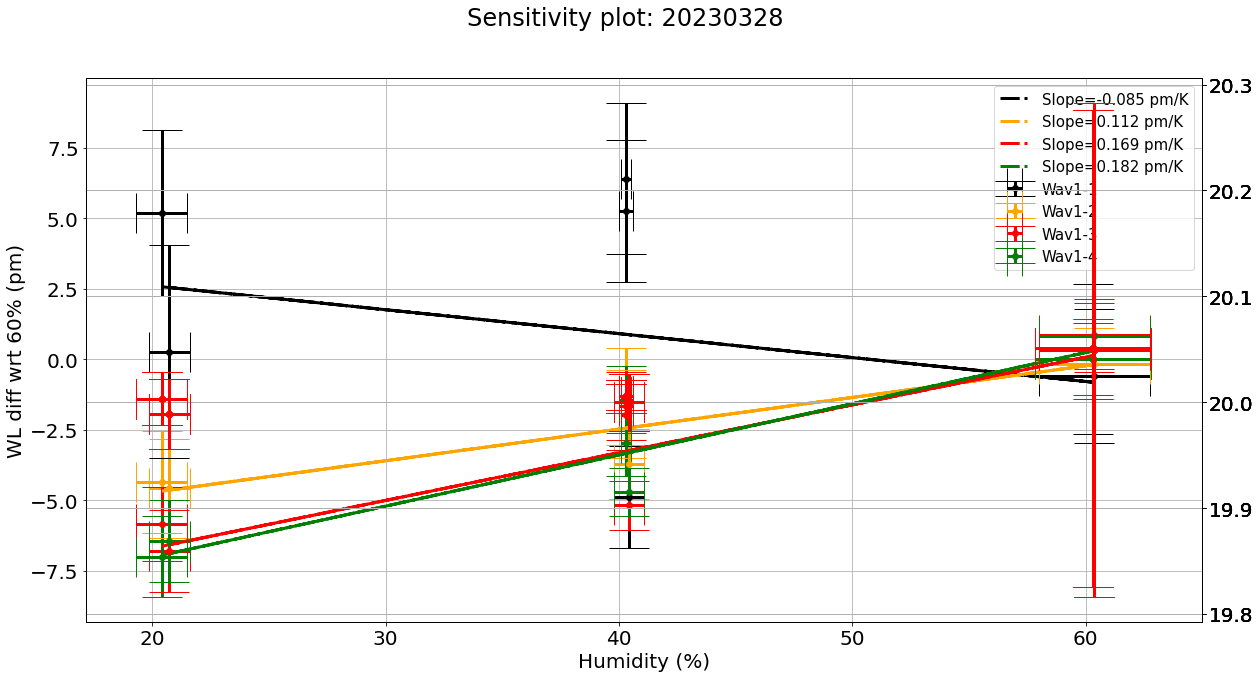

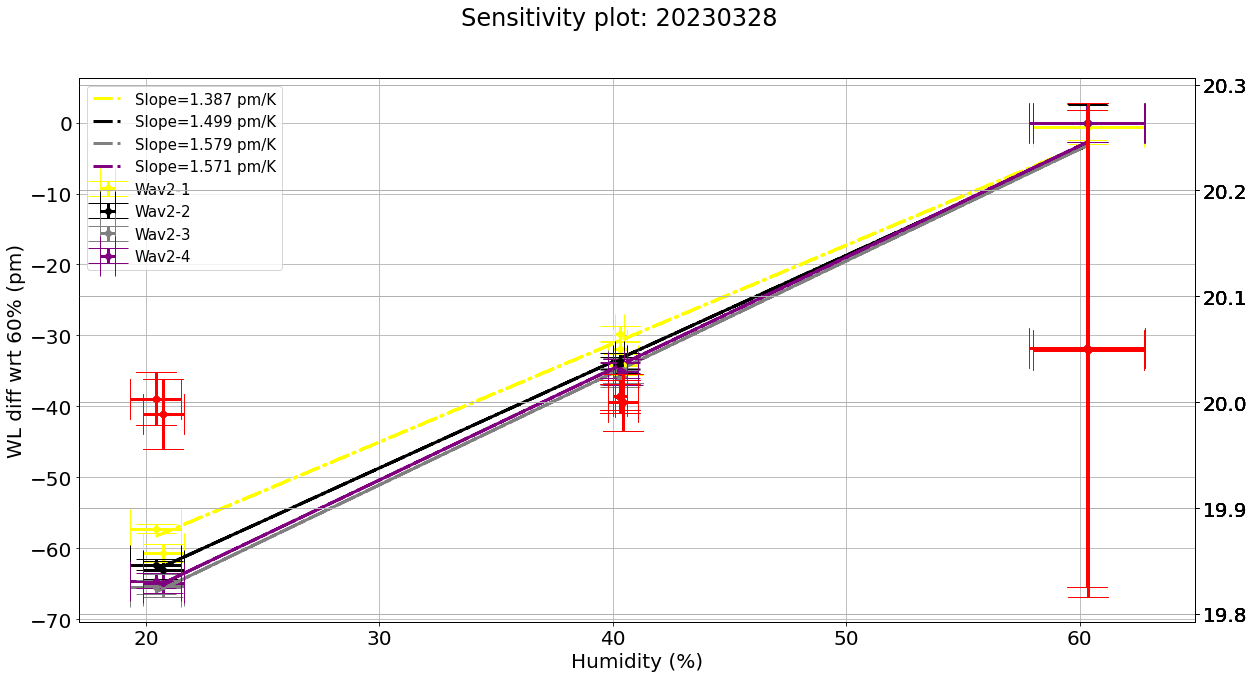

In [216]:
date = "20230328"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav2-1", "Wav2-2", "Wav2-3", "Wav2-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:01<00:00,  9.59it/s]


Keys to read: ['Temp1', 'Temp2']


Reading temperature key: Temp: 100%|██████████| 2/2 [00:00<00:00, 46.93it/s]


Keys to read: ['Hum1', 'Hum2']


Reading humidity key: Hum: 100%|██████████| 2/2 [00:00<00:00, 76.59it/s]


[789.97961161  13.17630549]
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 75.64it/s]


[767.2460732   12.83870858]
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 32.49it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 78.24it/s]


[821.1502196   13.81018361]


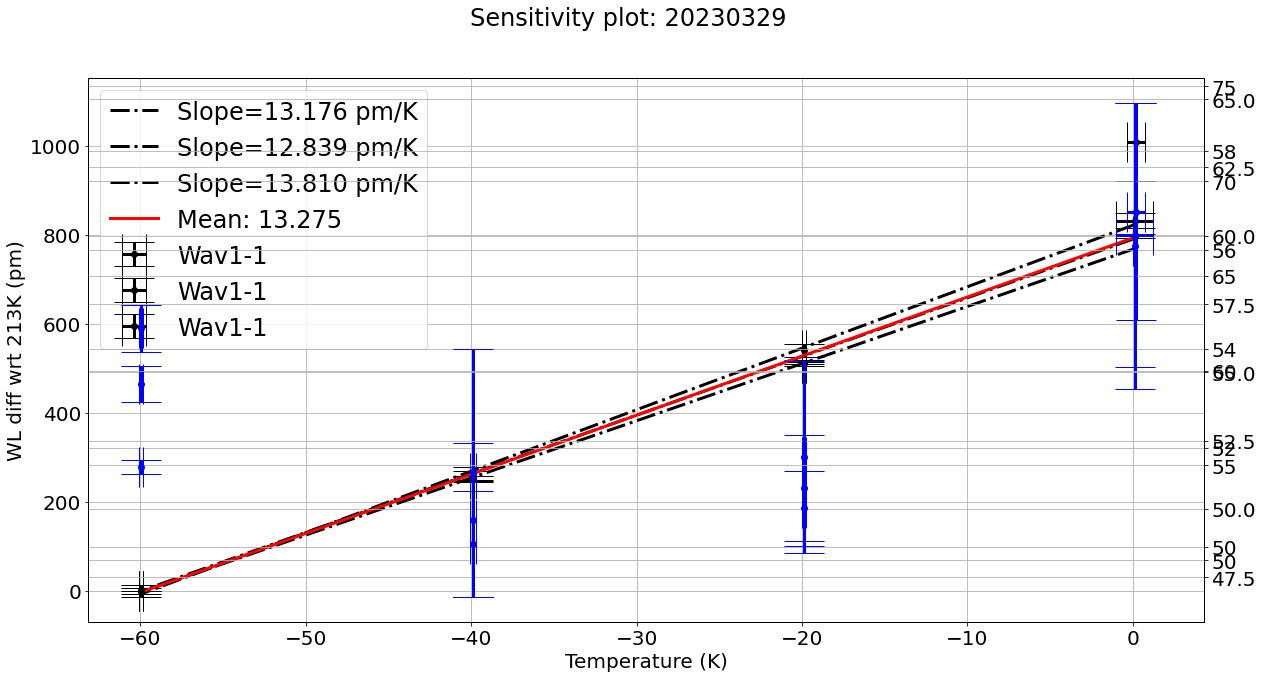

In [217]:
tdates = ["20230321", "20230322", "20230329"]
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
fig, axes = plt.subplots(nrows=1, ncols=1)
popts = []
T0 = []
for date in tdates:
    peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
    rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
    for sens in ["Wav1-1"]:
        temps, hums, wls, popt = plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)
        popts.append(popt[1])
        T0.append(popt[0])
axes.plot(temps, line(np.array(temps), np.mean(T0), np.mean(popts)),
          color="red", label=r"Mean: {0:.3f}".format(np.mean(popts)))
axes.legend()

Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 31.59it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 65.02it/s]


[89.38067966 -1.45025536]
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:03<00:00,  6.26it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 65.74it/s]


[131.49640754  -2.27598641]
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 31.87it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 67.77it/s]


[ 4.29625611 -0.08483957]


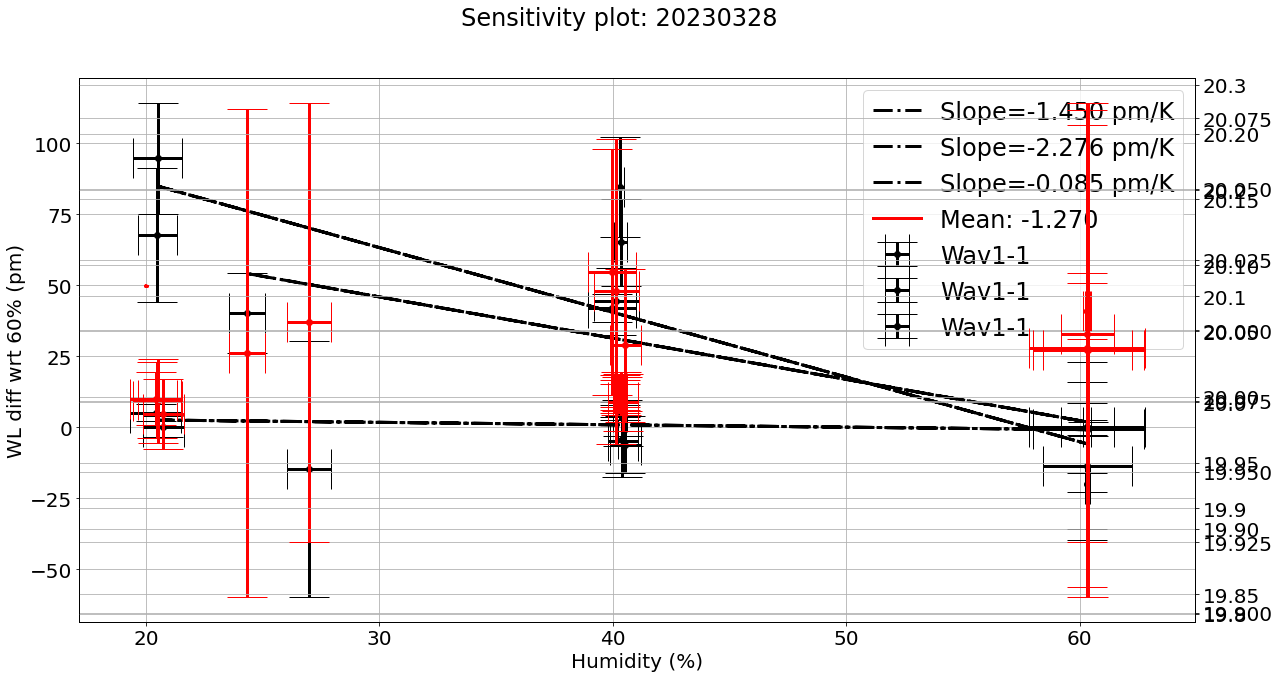

In [219]:
hdates = ["20230323", "20230327", "20230328"]
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
fig, axes = plt.subplots(nrows=1, ncols=1)
popts = []
T0 = []
for date in hdates:
    peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
    rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
    for sens in ["Wav1-1"]:
        temps, hums, wls, popt = plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)
        popts.append(popt[1])
        T0.append(popt[0])
axes.plot(temps, line(np.array(temps), np.mean(T0), np.mean(popts)),
          color="red", label=r"Mean: {0:.3f}".format(np.mean(popts)))
axes.legend()